## 모듈 추가
----- 

In [13]:
import cv2, os
import matplotlib.pyplot as plt
import numpy as np
import dlib, math

## 얼굴인식하기
------


### 얼굴 이미지 불러오기

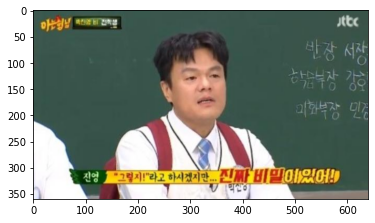

In [4]:
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/jyp1.jpg'
img_bgr = cv2.imread(my_image_path,cv2.IMREAD_UNCHANGED)    #- OpenCV로 이미지를 읽어서
img_bgr = cv2.resize(img_bgr, (640, 360))    # 640x360의 크기로 Resize
img_show = img_bgr.copy()      #- 출력용 이미지 별도 보관
img_show = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)

# 이미지 RGB로 변경 
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

plt.imshow(img_show) 
plt.show()

### 이미지에서 얼굴인식하기

In [5]:
detector_hog = dlib.get_frontal_face_detector()

rectangles[[(270, 92) (378, 199)]]


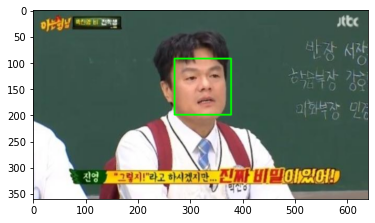

In [6]:
dlib_rects = detector_hog(img_show, 1)

print(dlib_rects)

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()
    
    cv2.rectangle(img_show,(l,t), (r,b), (0, 255,0), 2, lineType=cv2.LINE_AA)
    
plt.imshow(img_show)
plt.show()

### face landmark 모델 추가

In [7]:
import os
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)
print("🌫🛸")

🌫🛸


### face landmark 생성 및 표현

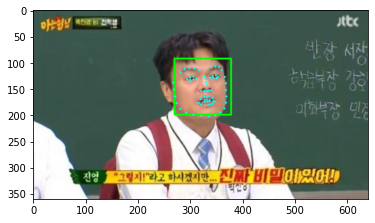

68


In [8]:
list_landmarks = []
# 사진에서 얼굴 인식하여 랜드마크 좌표 생성
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_show, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

# 생성된 랜드마크를 사진 위에 표현
for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow

plt.imshow(img_show)
plt.show()    
print(len(list_landmarks[0]))

#### 랜드마크의 번호별 위치

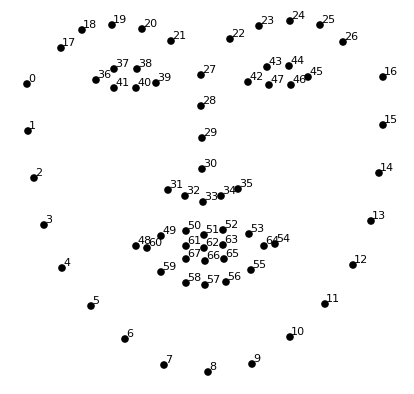

### 스티커 합성에 사용될 랜드마크 지정 

In [25]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    # 이미지 들어갈 랜드마크
    x_nose = landmark[33][0]
    y_nose = landmark[33][1]
    x_right = landmark[14][0]
    y_bottom = landmark[8][1]
    # 이미지의 기울기를 구하기 위한 랜드마크 
    x_left_eye = landmark[2][0]
    y_left_eye = landmark[2][1]
    x_right_eye = landmark[14][0]
    y_right_eye = landmark[14][1]
    
    print(f'x_nose, y_nose: {x_nose, y_nose}')
    print(f'(x_right): {x_right }')
    print(f'(y_bottm): {y_bottom}')
    print(f'(x_right_eye, y_right_eye): {x_right_eye},{y_right_eye}')
    print(f'(x_left_eye, y_left_eye): {x_left_eye},{y_left_eye}')

x_nose, y_nose: (332, 154)
(x_right): 368
(y_bottm): 202
(x_right_eye, y_right_eye): 368,152
(x_left_eye, y_left_eye): 271,164


## 스티커 이미지에서 배경 제거 후 합성하기
-----

### 스티커 이미지 로드 / 리사이징 / 기울이기
> 스티커 이미지를 리사이징 할 때 **코끝이 합성될 이미지의 정중앙**에 위치하게 하기 위해
**오른쪽 볼 끝의 x좌표 - 코의 x좌표**, 턱끝인 **랜드마크 8번의 y좌표 - 코의 y좌표** 를 한 후
각각의 값을 **2배**하여 **합성될 이미지의 x,y전체 길이로 설정**하였다.

* 이미지 기울이기는 [전지은 수강생의 agit 게시글](https://aiffel.agit.io/g/300308438/wall/324059380)과 [gramman document](https://opencv-python.readthedocs.io/en/latest/doc/10.imageTransformation/imageTransformation.html) 참조

half_y, half_x: 50, 46
h, w: 2, 136
angle: 0.8425242607404145
M: [[ 0.99989189  0.01470429 -0.67099175]
 [-0.01470429  0.99989189  0.74018786]]


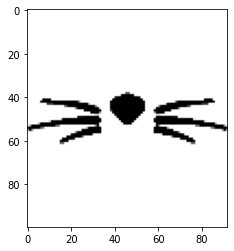

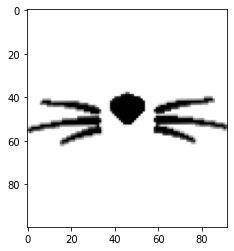

In [81]:
# 스티커 이미지 불러오기
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat-whiskers2.png'
img_sticker = cv2.imread(sticker_path)

# 스티커 이미지 리사이징
size_ratio = 1.5 # 이 값을 조절하여 합성될 이미지의 크기를 비율로 정할 수 있다.
half_x , half_y = round((x_right - x_nose)*size_ratio), round((y_bottom - y_nose)*size_ratio) # 합성 이미지의 가로,세로 1/2 길이 산출
print(f'half_y, half_x: {half_y}, {half_x}')
img_sticker = cv2.resize(img_sticker, (half_x * 2, half_y * 2)) # 얼굴 인식 영역에 맞춰서 스티커크기 조정

# 스티커 이미지 기울이기
h =  y_right_eye - y_left_eye
w =  x_right_eye - x_left_eye
print(f'h, w: {h}, {w}')
angle = math.atan(h/w)/math.pi*180 
if angle < 0:
    angle = -angle
print(f'angle: {angle}')
M = cv2.getRotationMatrix2D((img_sticker.shape[0]/2,img_sticker.shape[1]/2), angle, 1.0)
print(f'M: {M}')
rot_sticker = cv2.warpAffine(img_sticker, M,(img_sticker.shape[1], img_sticker.shape[0]), borderValue=(255,255,255))
plt.imshow(img_sticker)
plt.show()
plt.imshow(rot_sticker)
plt.show()

### 스티커 영역 설정

(refind_x_left,right): (278, 386)
(refind_y_top,bottm): (82, 226)
sticker_area


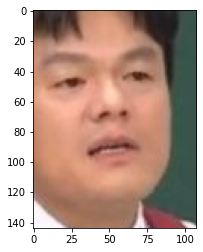

In [49]:
# sticker_area 설정: y,x순
refind_y_top = y_nose - half_y # 코의 x좌표에서 앞서 구한 합성될 이미지의 y축 절반의 길이를 빼서 y좌표 원점을 구한다.
refind_y_bottom = refind_y_top + img_sticker.shape[0] 
refind_x_left = x_nose - half_x # 코의 x좌표에서 앞서 구한 합성될 이미지의 x축 절반의 길이를 빼서 x좌표 원점을 구한다.
refind_x_right = refind_x_left + img_sticker.shape[1]
print(f'(refind_x_left,right): {refind_x_left, refind_x_right }')
print(f'(refind_y_top,bottm): {refind_y_top, refind_y_bottom}')

# img_rgb에서 sticker가 붙을 영역 지정하기
sticker_area = img_rgb[refind_y_top:refind_y_bottom, refind_x_left:refind_x_right]
print('sticker_area')
plt.imshow(sticker_area)
plt.show()

### 스티커이미지의 배경 제거후 스티커 영역에 합치기
* [gramman 0.1 documentation - 이미지연산](https://opencv-python.readthedocs.io/en/latest/doc/07.imageArithmetic/imageArithmetic.html) 참조
 

sticker_area


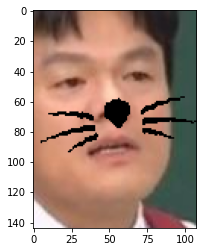

In [52]:
#mask를 만들기 위해서 img1을 gray로 변경 후, 
mask = cv2.cvtColor(rot_sticker, cv2.COLOR_BGR2GRAY)
#ret, mask = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)


#bitwise_and 연산자는 둘다 0이 아닌 경우만 값을 통과 시킴.
#즉 mask가 검정색이 아닌 경우만 통과가 되기때문에 mask영역 이외는 모두 제거됨.
sticker_area = cv2.bitwise_and(sticker_area, sticker_area, mask=mask)

print('sticker_area')
plt.imshow(sticker_area)
plt.show()

### 스티커 영역을 원본 이미지에 합치기

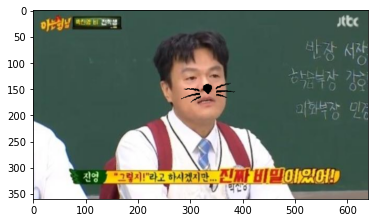

In [53]:
img_rgb[refind_y_top:refind_y_bottom, refind_x_left:refind_x_right] = np.where(sticker_area == 1, sticker_area, sticker_area).astype(np.uint8)
plt.imshow(img_rgb)
plt.show()

## 다른 조건으로 테스트
-----

### 1. 반대방향의 얼굴

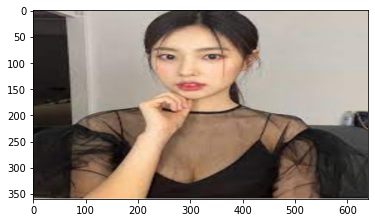

In [106]:
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/hyemmu2.jpeg'
img_bgr = cv2.imread(my_image_path,cv2.IMREAD_UNCHANGED)    #- OpenCV로 이미지를 읽어서
img_bgr = cv2.resize(img_bgr, (640, 360))    # 640x360의 크기로 Resize
img_show_hyem = img_bgr.copy()      #- 출력용 이미지 별도 보관
img_show_hyem = cv2.cvtColor(img_show_hyem, cv2.COLOR_BGR2RGB)

# 이미지 RGB로 변경 
img_rgb_hyem = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

plt.imshow(img_show_hyem) 
plt.show()

rectangles[[(225, 53) (354, 182)]]


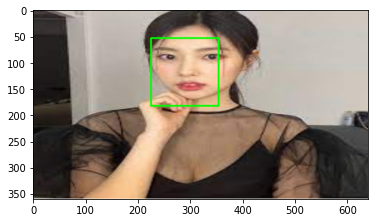

In [107]:
dlib_rects_hyem = detector_hog(img_show_hyem, 1)

print(dlib_rects_hyem)

for dlib_rect in dlib_rects_hyem:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()
    
    cv2.rectangle(img_show_hyem,(l,t), (r,b), (0, 255,0), 2, lineType=cv2.LINE_AA)
    
plt.imshow(img_show_hyem)
plt.show()

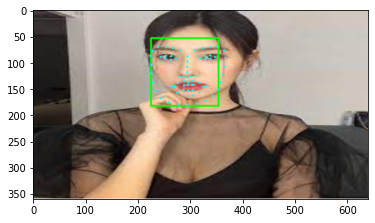

In [108]:
list_landmarks_hyem = []
# 사진에서 얼굴 인식하여 랜드마크 좌표 생성
for dlib_rect in dlib_rects_hyem:
    points = landmark_predictor(img_show_hyem, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks_hyem.append(list_points)

# 생성된 랜드마크를 사진 위에 표현
for landmark in list_landmarks_hyem:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show_hyem, point, 2, (0, 255, 255), -1) # yellow

plt.imshow(img_show_hyem)
plt.show()

x_nose, y_nose: (294, 128)
(x_right): 362
(y_bottm): 181
80 102


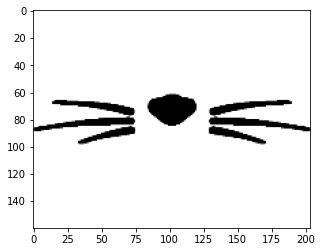

h, w: 2, 136
angle: -0.8425242607404145
M: [[ 0.99989189 -0.01470429  1.50848695]
 [ 0.01470429  0.99989189 -1.16531577]]


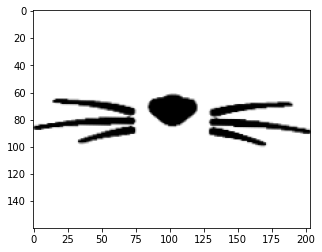

(refind_x_left,right): (192, 396)
(refind_y_top,bottm): (48, 208)
sticker_area


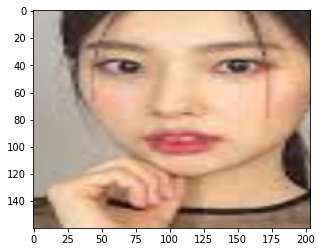

In [109]:
# 이미지 합성에 사용될 랜드마크 지정
for dlib_rects_hyem, list_landmarks_hyem  in zip(dlib_rects_hyem, list_landmarks_hyem):
    # 이미지 들어갈 랜드마크
    x_nose = landmark[33][0]
    y_nose = landmark[33][1]
    x_right = landmark[14][0]
    y_bottom = landmark[8][1]
    # 이미지의 기울기를 구하기 위한 랜드마크 
    x_left_eye = landmark[2][0]
    y_left_eye = landmark[2][1]
    x_right_eye = landmark[14][0]
    y_right_eye = landmark[14][1]
    
    print(f'x_nose, y_nose: {x_nose, y_nose}')
    print(f'(x_right): {x_right }')
    print(f'(y_bottm): {y_bottom}')

# 스티커 이미지 불러오기
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat-whiskers2.png'
img_sticker = cv2.imread(sticker_path)
    
# 스티커 이미지 리사이징
size_ratio = 1.5 # 이 값을 조절하여 합성될 이미지의 크기를 비율로 정할 수 있다.
half_x , half_y = round((x_right - x_nose)*size_ratio), round((y_bottom - y_nose)*size_ratio) # 합성 이미지의 가로,세로 1/2 길이 산출
print(half_y, half_x)
img_sticker = cv2.resize(img_sticker, (half_x * 2, half_y * 2)) # 얼굴 인식 영역에 맞춰서 스티커크기 조정
plt.imshow(img_sticker)
plt.show()

# 스티커 이미지 기울이기
h =  y_right_eye - y_left_eye
w =  x_right_eye - x_left_eye
print(f'h, w: {h}, {w}')
angle = math.atan(h/w)/math.pi*180 
angle = -angle
print(f'angle: {angle}')
M = cv2.getRotationMatrix2D((img_sticker.shape[0]/2,img_sticker.shape[1]/2), angle, 1.0)
print(f'M: {M}')
rot_sticker = cv2.warpAffine(img_sticker, M,(img_sticker.shape[1], img_sticker.shape[0]), borderValue=(255,255,255))
plt.imshow(rot_sticker)
plt.show()

# sticker_area 설정: y,x순
refind_y_top = y_nose - half_y
refind_y_bottom = refind_y_top + img_sticker.shape[0] 
refind_x_left = x_nose - half_x
refind_x_right = refind_x_left + img_sticker.shape[1]
print(f'(refind_x_left,right): {refind_x_left, refind_x_right }')
print(f'(refind_y_top,bottm): {refind_y_top, refind_y_bottom}')

# img_rgb에서 sticker가 붙을 영역 지정하기
sticker_area_hyem = img_rgb_hyem[refind_y_top:refind_y_bottom, refind_x_left:refind_x_right]
print('sticker_area')
plt.imshow(sticker_area_hyem)
plt.show()

sticker_area_hyem


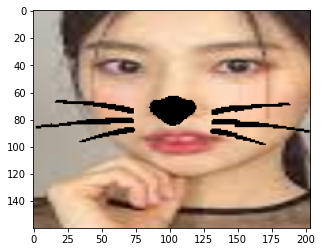

In [110]:
#mask를 만들기 위해서 img1을 gray로 변경
mask_hyem = cv2.cvtColor(rot_sticker, cv2.COLOR_BGR2GRAY)
#ret, mask_hyem = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY)


#bitwise_and 연산자는 둘다 0이 아닌 경우만 값을 통과 시킴.
#즉 mask가 검정색이 아닌 경우만 통과가 되기때문에 mask영역 이외는 모두 제거됨.
sticker_area_hyem = cv2.bitwise_and(sticker_area_hyem, sticker_area_hyem, mask=mask_hyem)

print('sticker_area_hyem')
plt.imshow(sticker_area_hyem)
plt.show()

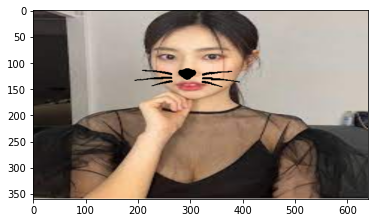

In [111]:
img_rgb_hyem[refind_y_top:refind_y_bottom, refind_x_left:refind_x_right] = np.where(sticker_area_hyem == 1, sticker_area_hyem, sticker_area_hyem).astype(np.uint8)
plt.imshow(img_rgb_hyem)
plt.show()

> rectangle의 영역이 실제 얼굴보다 좁게 인식되어 이미지의 x축이 줄어들었으나, 랜드마크를 사용한 좌표설정은 잘 동작하였다.

### 2. 기울어진 얼굴 + 클로즈 아웃

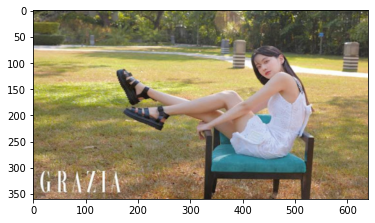

In [129]:
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/Ohyeon1.jpg'
img_bgr = cv2.imread(my_image_path,cv2.IMREAD_UNCHANGED)    #- OpenCV로 이미지를 읽어서
img_bgr = cv2.resize(img_bgr, (640, 360))    # 640x360의 크기로 Resize
img_show_oh = img_bgr.copy()      #- 출력용 이미지 별도 보관
img_show_oh = cv2.cvtColor(img_show_oh, cv2.COLOR_BGR2RGB)

# 이미지 RGB로 변경 
img_rgb_oh = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

plt.imshow(img_show_oh) 
plt.show()

rectangles[[(425, 94) (461, 130)]]


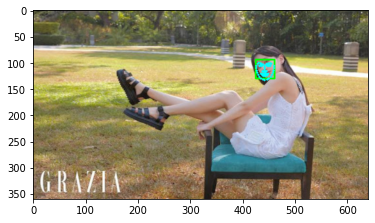

In [130]:
# 얼굴인식
dlib_rects = detector_hog(img_show_oh, 1)

print(dlib_rects)

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()
    
    cv2.rectangle(img_show_oh,(l,t), (r,b), (0, 255,0), 2, lineType=cv2.LINE_AA)
    
list_landmarks_oh = []

# 얼굴 랜드마크 좌표 생성
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_show_hyem, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks_oh.append(list_points)

    
# 생성된 랜드마크를 사진 위에 표현    
for landmark in list_landmarks_oh:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show_oh, point, 2, (0, 255, 255), -1) # yellow

plt.imshow(img_show_oh)
plt.show()

> rectangles 객체가 생성되었으나 페이스 랜드마크 생성시 얼굴의 기울기를 정확히 인식하지 못했다.
사진의 크기를 키워본다.

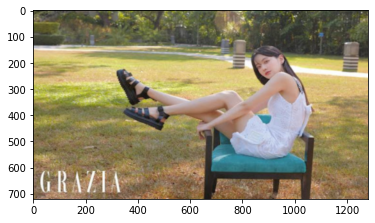

In [131]:
img_bgr = cv2.resize(img_bgr, (1280, 720))    # 640x360의 크기로 Resize
img_show_oh = img_bgr.copy()      #- 출력용 이미지 별도 보관
img_show_oh = cv2.cvtColor(img_show_oh, cv2.COLOR_BGR2RGB)

# 이미지 RGB로 변경 
img_rgb_oh = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

plt.imshow(img_show_oh) 
plt.show()

rectangles[[(851, 188) (925, 262)]]


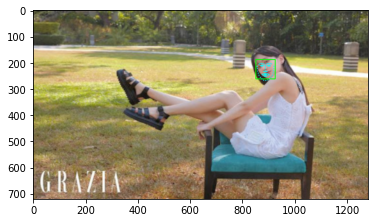

In [132]:
dlib_rects = detector_hog(img_show_oh, 1)

print(dlib_rects)

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()
    
    cv2.rectangle(img_show_oh,(l,t), (r,b), (0, 255,0), 2, lineType=cv2.LINE_AA)
    
list_landmarks_oh = []

# 얼굴 랜드마크 좌표 생성
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_show_hyem, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks_oh.append(list_points)

    
# 생성된 랜드마크를 사진 위에 표현    
for landmark in list_landmarks_oh:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show_oh, point, 2, (0, 255, 255), -1) # yellow

plt.imshow(img_show_oh)
plt.show()

> 여전히 같은 증상이 나타난다. 이 부분은 face landmark의 생성방식에 대한 공부가 필요할 것 같다. 

x_nose, y_nose: (888, 235)
(x_right): 919
(y_bottm): 268
50 46


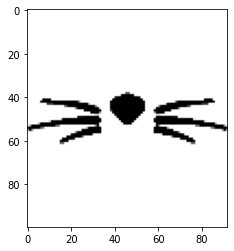

h, w: 2, 136
angle: 0.8425242607404145
M: [[ 0.99989189  0.01470429 -0.67099175]
 [-0.01470429  0.99989189  0.74018786]]


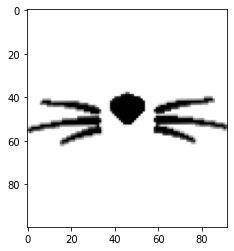

(refind_x_left,right): (842, 934)
(refind_y_top,bottm): (185, 285)
sticker_area


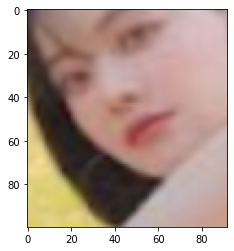

In [133]:
# 이미지 합성에 사용될 랜드마크 지정
for dlib_rect, list_landmarks_oh  in zip(dlib_rects, list_landmarks_oh ):
    # 이미지 들어갈 랜드마크
    x_nose = landmark[33][0]
    y_nose = landmark[33][1]
    x_right = landmark[14][0]
    y_bottom = landmark[8][1]
    
    print(f'x_nose, y_nose: {x_nose, y_nose}')
    print(f'(x_right): {x_right }')
    print(f'(y_bottm): {y_bottom}')

# 스티커 이미지 불러오기
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat-whiskers2.png'
img_sticker = cv2.imread(sticker_path)    
    
# 스티커 이미지 리사이징
size_ratio = 1.5 # 이 값을 조절하여 합성될 이미지의 크기를 비율로 정할 수 있다.
half_x , half_y = round((x_right - x_nose)*size_ratio), round((y_bottom - y_nose)*size_ratio) # 합성 이미지의 가로,세로 1/2 길이 산출
print(half_y, half_x)
img_sticker = cv2.resize(img_sticker, (half_x * 2, half_y * 2)) # 얼굴 인식 영역에 맞춰서 스티커크기 조정
plt.imshow(img_sticker)
plt.show()
    
# 스티커 이미지 기울이기
h =  y_right_eye - y_left_eye
w =  x_right_eye - x_left_eye
print(f'h, w: {h}, {w}')
angle = math.atan(h/w)/math.pi*180 
print(f'angle: {angle}')
M = cv2.getRotationMatrix2D((img_sticker.shape[0]/2,img_sticker.shape[1]/2), angle, 1.0)
print(f'M: {M}')
rot_sticker = cv2.warpAffine(img_sticker, M,(img_sticker.shape[1], img_sticker.shape[0]), borderValue=(255,255,255))
plt.imshow(rot_sticker)
plt.show()    
    
# sticker_area 설정: y,x순
refind_y_top = y_nose - half_y
refind_y_bottom = refind_y_top + img_sticker.shape[0] 
refind_x_left = x_nose - half_x
refind_x_right = refind_x_left + img_sticker.shape[1]
print(f'(refind_x_left,right): {refind_x_left, refind_x_right }')
print(f'(refind_y_top,bottm): {refind_y_top, refind_y_bottom}')

# img_rgb에서 sticker가 붙을 영역 지정하기
sticker_area_oh = img_rgb_oh[refind_y_top:refind_y_bottom, refind_x_left:refind_x_right]
print('sticker_area')
plt.imshow(sticker_area_oh)
plt.show()

sticker_area_oh


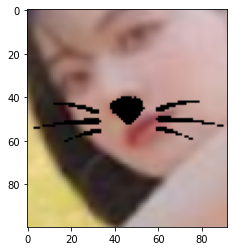

In [134]:
#mask를 만들기 위해서 이미지를 gray로 변경
mask_oh = cv2.cvtColor(rot_sticker, cv2.COLOR_BGR2GRAY)
#ret, mask = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)

#bitwise_and 연산자는 둘다 0이 아닌 경우만 값을 통과 시킴.
#즉 mask가 검정색이 아닌 경우만 통과가 되기때문에 mask영역 이외는 모두 제거됨.
sticker_area_oh = cv2.bitwise_and(sticker_area_oh, sticker_area_oh, mask=mask_oh)

print('sticker_area_oh')
plt.imshow(sticker_area_oh)
plt.show()

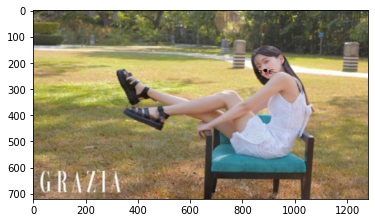

In [135]:
img_rgb_oh[refind_y_top:refind_y_bottom, refind_x_left:refind_x_right] = np.where(sticker_area_oh == 1, sticker_area_oh, sticker_area_oh).astype(np.uint8)
plt.imshow(img_rgb_oh)
plt.show()

> 얼굴이 **기울어지고, 클로즈 아웃된 이미지**에서도 **코끝을 중심으로 한 좌표설정이 잘 작동**하였다.
하지만 얼굴인식시 페이스 랜드마크게 올바르게 형성되지 않은 문제로 인해 **스티커의 기울기는 비정상적으로 작동**하였다.
해당 이미지의 **얼굴이 측면에서 촬영된 것을 페이스 랜드마크가 올바르게 반영하지 못하는 점**을 해결해야 정상적인 결과가 나올 것이다.

## 후기
-----

> 이번 exploration 노드도 진행하다보니 여러번의 난관이 있었지만 그래도 하나씩 해결되며 노드를 마무리 할 수 있었다.   
진행중에 겪었던 이슈사항들을 하나씩 정리해본다.

### 난관 1. 얼굴인식이 올바르게 적용되는 이미지를 수집하기

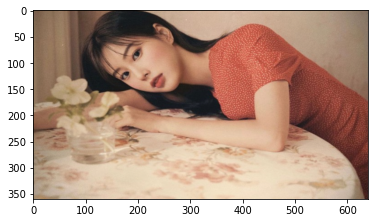

In [82]:
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/hyemmu1.png'
img_bgr = cv2.imread(my_image_path,cv2.IMREAD_UNCHANGED)    #- OpenCV로 이미지를 읽어서
img_bgr = cv2.resize(img_bgr, (640, 360))    # 640x360의 크기로 Resize
img_show1 = img_bgr.copy()      #- 출력용 이미지 별도 보관
img_show1 = cv2.cvtColor(img_show1, cv2.COLOR_BGR2RGB)

# 원본이미지 RGB로 변경 
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

plt.imshow(img_show1) 
plt.show()

rectangles[]


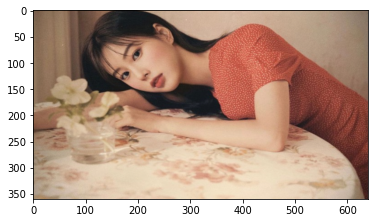

In [83]:
dlib_rects1 = detector_hog(img_show1, 1)

print(dlib_rects1)

for dlib_rect in dlib_rects1:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()
    
    cv2.rectangle(img_show1,(l,t), (r,b), (0, 255,0), 2, lineType=cv2.LINE_AA)
    
list_landmarks = []
# 사진에서 얼굴 인식하여 랜드마크 좌표 생성
for dlib_rect in dlib_rects1:
    points = landmark_predictor(img_show1, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)
    
for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show1, point, 2, (0, 255, 255), -1) # yellow

# 생성된 랜드마크를 사진 위에 표현
plt.imshow(img_show1)
plt.show()    

얼굴인식에 실패하여 rectangles 객체가 아무런 요소도 갖고 있지 않다.

#### 이처럼 수집한 이미지에 얼굴인식을 시도하다보면 여러가지 실패 케이스들이 발생했다.

1. 이미지 리사이징 과정에서 가로세로 비율 유지 실패
2. rectangles 객체 생성 실패
3. 얼굴이 아닌 위치에 rectangles 생성
4. 얼굴의 일부분에만 rectangles 생성
5. rectagles 객체 생성 했으나 페이스 랜드마크를 틀리게 생성

4번과 5번의 경우 앞서 반대방향얼굴 인식 테스트에서처럼 이후의 작업에 지장이 없는 경우도 있었으나, 1~3번의 케이스는 그 이후의 단계로 전혀 진행할 수 없고, 4번의 경우도 높은 확률로 다음 단계로 진행할 수 없었다. 

이와 같은 실패 케이스에 해당하지 않는 정상적인 케이스를 찾는 것이 생각 이상으로 시간이 걸렸는데, 만약 앞으로 있을 해커톤에서 **얼굴인식을 활용한 어플리케이션을 개발하게 된다면 먼저 얼굴인식의 성공률을 높이기 위한 방안을 찾는 것부터 시작해야**할 것 같다. 이를 위해선 dlib.get_frontal_face_detector에 대한 확실한 이해가 필요할 것이다.

### 난관 2. 노드의 예제코드 이해하기

이번 노드에서는 예제코드의 의미를 이해하는데 매우 많은 시간을 할애했다.
특히 **합성할 이미지의 기준점을 잡는 부분의 코드진행을 이해하는데 골머리**를 앓았다.
한동안 헤맨 끝에 의미가 분명한 변수명을 새로 할당하는 것부터 시작해보니 조금씩 이해가 되기 시작했다.

**합성될 이미지의 좌표를 설정한 방식은 다음과 같다.**

1. ```python
      x_nose = landmark[33][0]
      y_nose = landmark[33][1]
      x_right = landmark[14][0]
      y_bottom = landmark[8][1]
   ```
   
   **코끝(landmark[33])의 x,y**좌표, **오른쪽 볼(landmark[14])의 x**좌표, **턱끝(landmark[8])의 y**좌표를 각각 x/y_nose, x_right, y_bottome에 할당 
2. 
   ```python
   half_x = round((x_right - x_nose)*size_ratio)     # 합성될 이미지의 x 길이 * 0.5
   half_y = round((y_bottom - y_nose)*size_ratio)    # 합성될 이미지의 y 길이 * 0.5
   ```
   합성될 이미지의 크기를 위 두 변수 값의 두배로 리사이징 한다. 이때 size_ratio에 이미지의 비율을 정해주면 그만큼 확대, 축소 된다.
3. ```python 
   x_left = x_nose - half_x  # 합성될 이미지의 x 원점 
   y_top = y_nose - half_y   # 합성될 이미지의 y 원점
   ```
   **x_left + 합성될 이미지의 x 길이, y_top + 합성될 이미지의 y길이**로 이미지가 **합성될 영역**을 구할 수 있다. 

### 난관 3. png 이미지의 배경을 투명하게 만들기

노드에서 제공한 **이미지의 형식이 png**였으므로, 기본적으로 배경이 투명으로 처리되어 있을 것이라 예상했지만 실제 이미지를 합성한 결과는 **흰색의 불투명한 픽셀**들이 가득 차있었다.

처음에는 이미지를 로드할 때 alpha 채널을 살리지 않은 것이 문제인 줄알고

```python
img_bgr = cv2.imread(my_image_path,cv2.IMREAD_UNCHANGED) # 원본 이미지의 형식을 그대로 보존
img_bgr = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2BGRA)      # BGR -> BGRA  
img_bgr = cv2.cvtColor(img_bgr, cv2.COLOR_BGRA2RGBA)     # BGRA -> RGBA
```
위와 같이 alpha 채널을 가진 RGB 이미지로 변환해주었으나, 합성된 이미지의 배경은 그대로 였다.

고민끝에 찾아낸 방법은 아래처럼 cv2.bitwise_and 메소드를 사용해 합성될 이미지에서 검정색인 부분만 sticker_area에 남도록 하는 것이었다.

```python
mask = cv2.cvtColor(rot_sticker, cv2.COLOR_BGR2GRAY)

sticker_area = cv2.bitwise_and(sticker_area, sticker_area, mask=mask)
```

이번 노드에 사용된 스티커이미지가 기본적으로 흑백이어서 grayscale만 수행하여도 마스크의 역할을 잘 수행하였다.
컬러이미지의 경우 [추가적인 가공](https://opencv-python.readthedocs.io/en/latest/doc/07.imageArithmetic/imageArithmetic.html#id3)이 더 필요하다.

### 이번 노드를 통해 배운 것들

#### 1. dlib 라이브러리 사용   
   1) regtangles 객체 다루기   
   2) face landmark 다루기   
   

#### 2. cv2 라이브러리 사용   
   1) 이미지의 컬러스페이스 다루기   
   2) 이미지의 크기, 기울기 조절   
   3) 비트와이즈 앤드 연산을 통한 배경 제거 및 합성   


### 아쉬웠던 것 및 느낀점

#### 1. rectangles 객체 및 페이스 랜드마크가 생성되는 과정에 대한 이해가 부족하다.
이후의 모든 작업에 영향을 주는 가장 중요한 데이터처리 과정이지만, 노드의 완성이 보다 중요한 목표였기 때문에 깊이 있게 파고들수 없었다. 완성도 있는 얼굴인식 어플리케이션의 개발을 목표로 한다면 한 번은 제대로 공부해야겠다는 판단이 들었다.

#### 2. 이미지 데이터의 자료구조가 낯설어서 각종 메소드를 볼 때 이해하는데 시간의 소요가 많았다.
이미지가 매트릭스 형태의 배열 객체라는 것은 알고 있지만, 그것을 처리하는 과정을 100% 다 이해할 수는 없었다. 이미 만들어진 메소드들의 사용법을 익히는 것 만으로도 이번 노드를 진행해낼 수 있었지만, 보다 능숙한 처리를 위해서는 이미지 데이터의 자료구조에 대한 이해도를 더 높여야 할 것이다.
